In [17]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sys
import os
import pickle
import librosa
import librosa.display
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np


In [19]:
import os
import librosa
# Contoh path absolut di Windows
audio_data = 'C:/Users/gus ryan/iDev/music-classification-models/Data/genres_original/jazz/jazz.00011.wav'

if os.path.exists(audio_data):
    data, sr = librosa.load(audio_data)
    print(type(data), type(sr))
else:
    print("File tidak ditemukan di path yang diberikan:", audio_data)


<class 'numpy.ndarray'> <class 'int'>


In [20]:
librosa.load(audio_data, sr=45000)

(array([0.08762547, 0.1337555 , 0.13862577, ..., 0.19162615, 0.15596236,
        0.0757204 ], dtype=float32),
 45000)

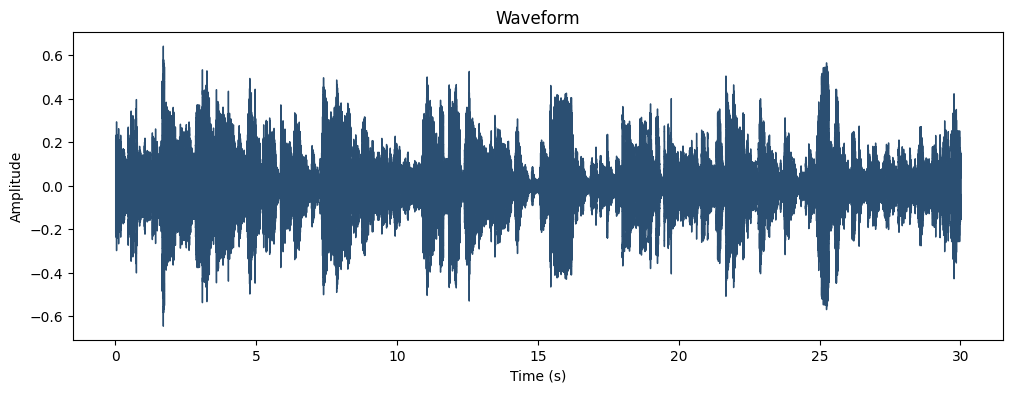

In [21]:
import matplotlib.pyplot as plt
import librosa.display

# Memuat file audio
audio_data = 'C:/Users/gus ryan/iDev/music-classification-models/Data/genres_original/jazz/jazz.00011.wav'
data, sr = librosa.load(audio_data)

# Menampilkan gelombang audio
plt.figure(figsize=(12, 4))
librosa.display.waveshow(data, sr=sr, color="#2B4F72")
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()


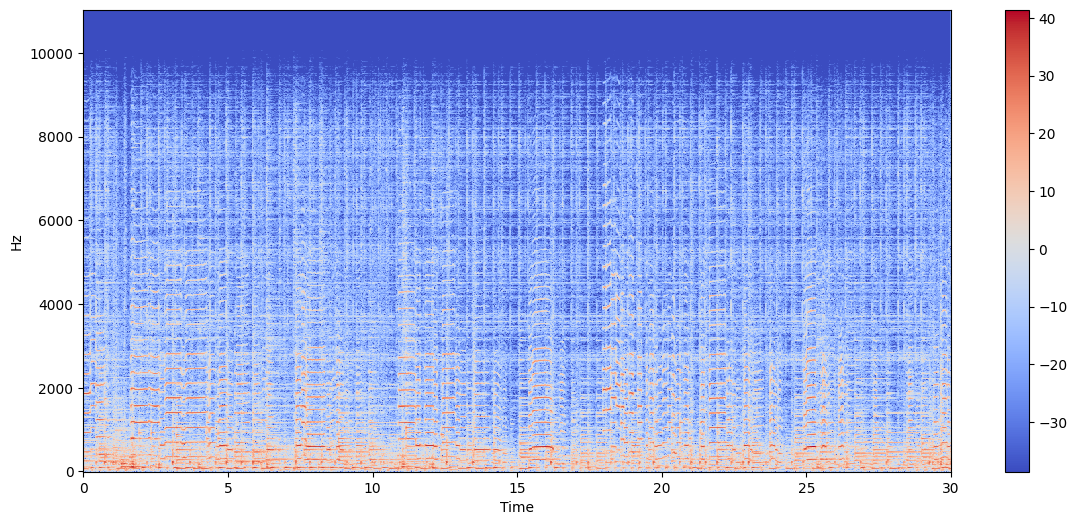

In [22]:
X = librosa.stft(data)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 6))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

The vertical axis represents frequencies (from 0 to 10kHz), and the horizontal axis represents the time of the clip. 


Let's Convert the frequency axis to a logarithm , because we see that all actions (in red) is taking place at the bottom of the spectrum.

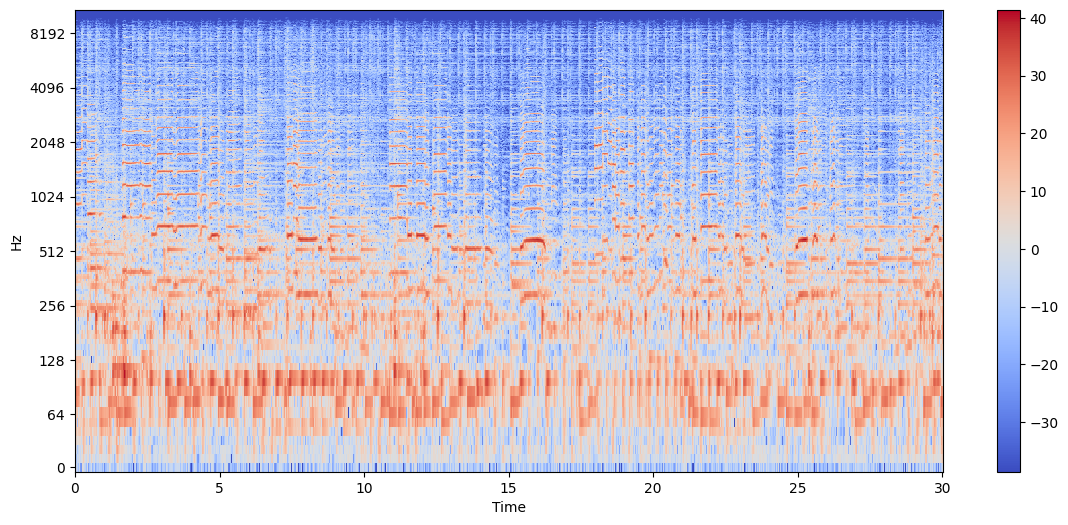

In [23]:
plt.figure(figsize=(14, 6))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

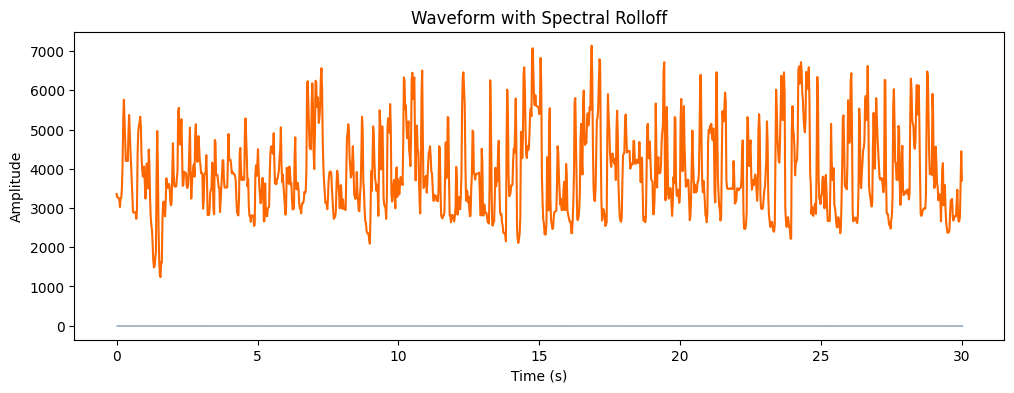

In [24]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
from sklearn.preprocessing import normalize

# Memuat file audio
audio_data = 'C:/Users/gus ryan/iDev/music-classification-models/Data/genres_original/jazz/jazz.00011.wav'
data, sr = librosa.load(audio_data)

# Menghitung spectral rolloff
spectral_rolloff = librosa.feature.spectral_rolloff(y=data+0.01, sr=sr)[0]

# Menampilkan gelombang audio
plt.figure(figsize=(12, 4))
librosa.display.waveshow(data, sr=sr, alpha=0.4, color="#2B4F75")
plt.title('Waveform with Spectral Rolloff')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Menambahkan spectral rolloff ke plot
plt.plot(librosa.times_like(spectral_rolloff, sr=sr), spectral_rolloff, color='#FD6700')
plt.show()


**Classification**

Dataset kami ini memiliki 10 jenis genre :
*   Blues
*   Classical
*   Country
*   Disco
*   Hiphop
*   Jazz
*   Metal
*   Pop
*   Reggae
*   Rock

import os
import glob
import librosa
import numpy as np
import pandas as pd

# Function to extract features from an audio file
def extract_features(file_path, index):
    try:
        y, sr = librosa.load(file_path, sr=None, duration=5.0)  # Load only the first 5 seconds
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

    features = {}

    features['filename'] = f"{os.path.basename(file_path)}.{index}"
    features['length'] = len(y) / sr
    features['chroma_stft_mean'] = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))
    features['chroma_stft_var'] = np.var(librosa.feature.chroma_stft(y=y, sr=sr))
    features['rms_mean'] = np.mean(librosa.feature.rms(y=y))
    features['rms_var'] = np.var(librosa.feature.rms(y=y))
    features['spectral_centroid_mean'] = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    features['spectral_centroid_var'] = np.var(librosa.feature.spectral_centroid(y=y, sr=sr))
    features['spectral_bandwidth_mean'] = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    features['spectral_bandwidth_var'] = np.var(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    features['rolloff_mean'] = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    features['rolloff_var'] = np.var(librosa.feature.spectral_rolloff(y=y, sr=sr))
    features['zero_crossing_rate_mean'] = np.mean(librosa.feature.zero_crossing_rate(y))
    features['zero_crossing_rate_var'] = np.var(librosa.feature.zero_crossing_rate(y))
    features['harmony_mean'] = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr))
    features['harmony_var'] = np.var(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr))
    features['perceptr_mean'] = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20))
    features['perceptr_var'] = np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20))
    features['tempo'] = librosa.feature.rhythm.tempo(y=y, sr=sr)[0]

    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    for i in range(1, 21):
        features[f'mfcc{i}_mean'] = np.mean(mfccs[i-1])
        features[f'mfcc{i}_var'] = np.var(mfccs[i-1])

    features['label'] = os.path.basename(os.path.dirname(file_path))  # Use the folder name as the label

    return features

# Directory containing audio files
audio_dir = 'C:/Users/gus ryan/iDev/music-classification-models/Data/genres_original'

# List all audio files in the directory and subdirectories
audio_files = glob.glob(os.path.join(audio_dir, '**', '*.wav'), recursive=True)

# Extract features from each audio file 15 times
feature_list = []
for index in range(20):
    for file in audio_files:
        features = extract_features(file, index + 1)
        if features:
            feature_list.append(features)

# Create a DataFrame
df = pd.DataFrame(feature_list)

# Save DataFrame to CSV
df.to_csv('audio_features.csv', index=False)

print(df.head())

import os
import glob
import librosa
import numpy as np
import pandas as pd

# Function to extract features from an audio file
def extract_features(file_path, index, offset):
    try:
        y, sr = librosa.load(file_path, sr=None, offset=offset, duration=5.0)  # Load audio with offset
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

    features = {}

    features['filename'] = f"{os.path.basename(file_path)}.{index}"
    features['length'] = len(y) / sr
    features['chroma_stft_mean'] = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))
    features['chroma_stft_var'] = np.var(librosa.feature.chroma_stft(y=y, sr=sr))
    features['rms_mean'] = np.mean(librosa.feature.rms(y=y))
    features['rms_var'] = np.var(librosa.feature.rms(y=y))
    features['spectral_centroid_mean'] = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    features['spectral_centroid_var'] = np.var(librosa.feature.spectral_centroid(y=y, sr=sr))
    features['spectral_bandwidth_mean'] = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    features['spectral_bandwidth_var'] = np.var(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    features['rolloff_mean'] = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    features['rolloff_var'] = np.var(librosa.feature.spectral_rolloff(y=y, sr=sr))
    features['zero_crossing_rate_mean'] = np.mean(librosa.feature.zero_crossing_rate(y))
    features['zero_crossing_rate_var'] = np.var(librosa.feature.zero_crossing_rate(y))
    features['harmony_mean'] = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr))
    features['harmony_var'] = np.var(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr))
    features['perceptr_mean'] = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20))
    features['perceptr_var'] = np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20))
    features['tempo'] = librosa.feature.rhythm.tempo(y=y, sr=sr)[0]

    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    for i in range(1, 21):
        features[f'mfcc{i}_mean'] = np.mean(mfccs[i-1])
        features[f'mfcc{i}_var'] = np.var(mfccs[i-1])

    features['label'] = os.path.basename(os.path.dirname(file_path))  # Use the folder name as the label

    return features

# Directory containing audio files
audio_dir = 'C:/Users/gus ryan/iDev/music-classification-models/Data/genres_original'

# List all audio files in the directory and subdirectories
audio_files = glob.glob(os.path.join(audio_dir, '**', '*.wav'), recursive=True)

# Extract features from each audio file multiple times with different offsets
feature_list = []
offset_increment = 3.0  # Increment offset by 3 seconds each iteration

for file in audio_files:
    offset = 0
    index = 1
    while offset + 5.0 <= librosa.get_duration(filename=file):  # Ensure we don't exceed the audio length
        features = extract_features(file, index, offset)
        if features:
            feature_list.append(features)
        offset += offset_increment
        index += 1

# Create a DataFrame
df = pd.DataFrame(feature_list)

# Save DataFrame to CSV
df.to_csv('audio_5_features.csv', index=False)

print(df.head())


In [52]:
from sklearn.preprocessing import StandardScaler
import pickle

# Load the DataFrame
df = pd.read_csv('audio_5_features.csv')

# Separate features and labels
X = df.drop(columns=['filename', 'label'])
y = df['label']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save the scaler
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

# Create a new DataFrame with scaled features
df_scaled = pd.DataFrame(X_scaled, columns=X.columns)
df_scaled['label'] = y.values

# Save the scaled features DataFrame to CSV
df_scaled.to_csv('audio_5_features_scaled.csv', index=False)

In [25]:
%matplotlib inline
from keras import layers
import keras

In [26]:
df1 = pd.read_csv('C:/Users/gus ryan/iDev/music-classification-models/audio_5_features.csv')
df1.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav.1,5.0,0.334510,0.088212,0.124171,0.002805,1778.840417,141560.190394,1976.265110,102507.590614,...,45.694313,-3.911385,37.965813,0.702705,43.591507,-2.843700,57.622360,2.808007,62.971160,blues
1,blues.00000.wav.2,5.0,0.346878,0.086148,0.115864,0.002538,1780.716559,91149.556434,2020.247132,68988.779728,...,69.075150,-3.667212,34.816097,0.498173,53.956320,-1.559210,86.446540,4.064406,51.691975,blues
2,blues.00000.wav.3,5.0,0.345369,0.089870,0.132954,0.003484,1742.333222,106964.146820,2041.819636,74082.711043,...,76.290276,-2.216898,29.549654,1.379054,40.652740,-1.830338,54.286224,2.697044,33.195942,blues
3,blues.00000.wav.4,5.0,0.354863,0.089026,0.132738,0.002026,1669.456059,97057.205370,1993.464750,62586.604265,...,43.081510,-2.191867,33.814507,0.963818,45.344193,-3.026349,41.518707,2.318284,36.571430,blues
4,blues.00000.wav.5,5.0,0.350790,0.089555,0.138807,0.002627,1824.595567,190401.830125,2059.250658,78955.072571,...,32.677570,0.078149,49.501650,0.000616,45.478954,-2.126732,24.974829,1.343286,33.798020,blues


In [27]:
df1.shape

(8991, 60)

In [28]:
df1.dtypes

filename                    object
length                     float64
chroma_stft_mean           float64
chroma_stft_var            float64
rms_mean                   float64
rms_var                    float64
spectral_centroid_mean     float64
spectral_centroid_var      float64
spectral_bandwidth_mean    float64
spectral_bandwidth_var     float64
rolloff_mean               float64
rolloff_var                float64
zero_crossing_rate_mean    float64
zero_crossing_rate_var     float64
harmony_mean               float64
harmony_var                float64
perceptr_mean              float64
perceptr_var               float64
tempo                      float64
mfcc1_mean                 float64
mfcc1_var                  float64
mfcc2_mean                 float64
mfcc2_var                  float64
mfcc3_mean                 float64
mfcc3_var                  float64
mfcc4_mean                 float64
mfcc4_var                  float64
mfcc5_mean                 float64
mfcc5_var           

Selanjutnya akan dilakukan penghapus kolom "filename" dan seluruh data yang ada di dalamnya

In [29]:
df1 = df1.drop(labels='filename',axis=1)

**Preprocessing the Data**

# Encode Kolom Label
Tahapan ini akan dilakukan proses encoding terhadap kolom label dengan menggunakan fungsi LabelEncoder() pada library sklearn.preprocessing.

In [30]:
genre_list = df1.iloc[:, -1]
encoder = LabelEncoder()

In [31]:
y = encoder.fit_transform(genre_list)

In [32]:
print(df1.iloc[:, :-1])

      length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0        5.0          0.334510         0.088212  0.124171  0.002805   
1        5.0          0.346878         0.086148  0.115864  0.002538   
2        5.0          0.345369         0.089870  0.132954  0.003484   
3        5.0          0.354863         0.089026  0.132738  0.002026   
4        5.0          0.350790         0.089555  0.138807  0.002627   
...      ...               ...              ...       ...       ...   
8986     5.0          0.333110         0.083536  0.048298  0.000074   
8987     5.0          0.356316         0.081288  0.054670  0.000124   
8988     5.0          0.343852         0.088629  0.048289  0.000205   
8989     5.0          0.378201         0.084462  0.061120  0.000642   
8990     5.0          0.387886         0.086204  0.058557  0.000290   

      spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0                1778.840417          141560.190394              19

In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(np.array(df1.iloc[:, :-1], dtype = float))

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [35]:
print(X_train.shape)
print(y_train.shape)

(7192, 58)
(7192,)


In [36]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
X_test=torch.tensor(X_test, dtype=torch.float32)
y_test=torch.tensor(y_test, dtype=torch.int64)

X_train = X_train.unsqueeze(1) 
X_test = X_test.unsqueeze(1) 


In [37]:
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
valset=TensorDataset(X_test, y_test)
val= DataLoader(valset, batch_size=128, shuffle=True)

In [38]:
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNNClassifier, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)
        
        
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])# Use only the last output
        out = self.softmax(out)
        return out


In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model Sebelum Tuning Hyperparameter 

In [66]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pickle

# Definisikan DataLoader dan model seperti sebelumnya
train_loader = DataLoader(dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(valset, batch_size=128, shuffle=False)

input_size = X_train.shape[1]
hidden_size = 64
num_classes = 10
model = RNNClassifier(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
best_val_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    epoch_val_loss = running_val_loss / total_val
    epoch_val_acc = correct_val / total_val

    print(
        f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}"
    )


Epoch [1/50], Train Loss: 2.2047, Train Acc: 0.3465, Val Loss: 2.0912, Val Acc: 0.4069
Epoch [2/50], Train Loss: 2.0520, Train Acc: 0.4440, Val Loss: 1.9883, Val Acc: 0.5381
Epoch [3/50], Train Loss: 1.9605, Train Acc: 0.5638, Val Loss: 1.9075, Val Acc: 0.6203
Epoch [4/50], Train Loss: 1.8987, Train Acc: 0.6160, Val Loss: 1.8619, Val Acc: 0.6565
Epoch [5/50], Train Loss: 1.8609, Train Acc: 0.6499, Val Loss: 1.8323, Val Acc: 0.6865
Epoch [6/50], Train Loss: 1.8347, Train Acc: 0.6732, Val Loss: 1.8115, Val Acc: 0.6965
Epoch [7/50], Train Loss: 1.8139, Train Acc: 0.6908, Val Loss: 1.7916, Val Acc: 0.7126
Epoch [8/50], Train Loss: 1.7933, Train Acc: 0.7111, Val Loss: 1.7772, Val Acc: 0.7265
Epoch [9/50], Train Loss: 1.7765, Train Acc: 0.7273, Val Loss: 1.7632, Val Acc: 0.7360
Epoch [10/50], Train Loss: 1.7629, Train Acc: 0.7362, Val Loss: 1.7535, Val Acc: 0.7404
Epoch [11/50], Train Loss: 1.7521, Train Acc: 0.7433, Val Loss: 1.7446, Val Acc: 0.7487
Epoch [12/50], Train Loss: 1.7432, Train 

# Mencari Hyperparameter Terbaik untuk Model

Epoch [1/50], Train Loss: 2.2358, Train Acc: 0.3053, Val Loss: 2.1550, Val Acc: 0.3674
Epoch [2/50], Train Loss: 2.1175, Train Acc: 0.3564, Val Loss: 2.0700, Val Acc: 0.4158
Epoch [3/50], Train Loss: 2.0520, Train Acc: 0.4366, Val Loss: 2.0088, Val Acc: 0.5047
Epoch [4/50], Train Loss: 1.9942, Train Acc: 0.5202, Val Loss: 1.9515, Val Acc: 0.5831
Epoch [5/50], Train Loss: 1.9439, Train Acc: 0.5784, Val Loss: 1.9086, Val Acc: 0.6153
Epoch [6/50], Train Loss: 1.9054, Train Acc: 0.6183, Val Loss: 1.8751, Val Acc: 0.6587
Epoch [7/50], Train Loss: 1.8756, Train Acc: 0.6514, Val Loss: 1.8495, Val Acc: 0.6804
Epoch [8/50], Train Loss: 1.8513, Train Acc: 0.6684, Val Loss: 1.8294, Val Acc: 0.6993
Epoch [9/50], Train Loss: 1.8318, Train Acc: 0.6849, Val Loss: 1.8138, Val Acc: 0.7098
Epoch [10/50], Train Loss: 1.8151, Train Acc: 0.6966, Val Loss: 1.7994, Val Acc: 0.7187
Epoch [11/50], Train Loss: 1.8002, Train Acc: 0.7120, Val Loss: 1.7875, Val Acc: 0.7187
Epoch [12/50], Train Loss: 1.7870, Train 

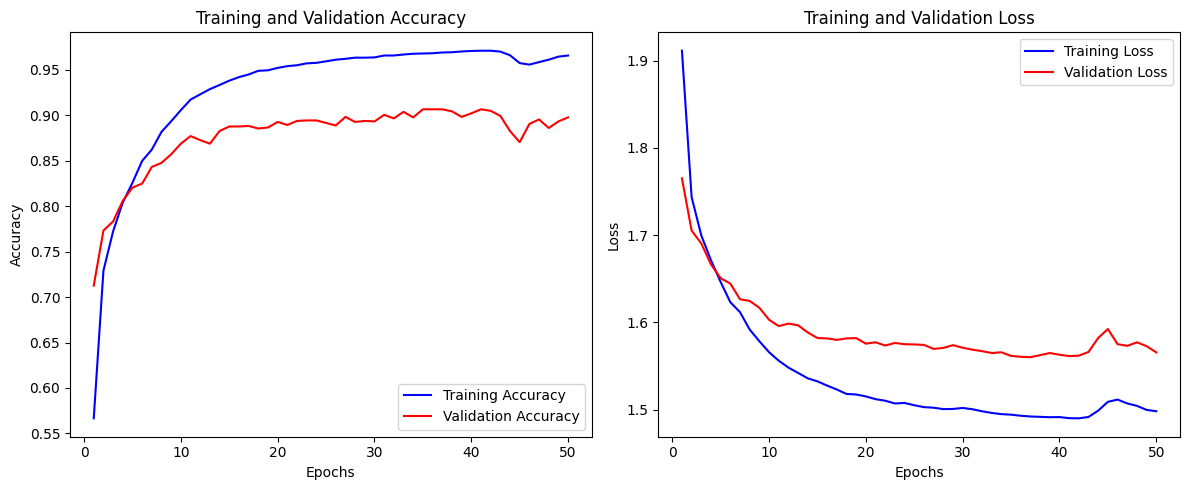

In [40]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pickle
from itertools import product
import matplotlib.pyplot as plt

def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    best_val_acc = 0.0
    train_acc_list = []
    val_acc_list = []
    train_loss_list = []
    val_loss_list = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = correct / total

        train_loss_list.append(epoch_loss)
        train_acc_list.append(epoch_acc)

        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        epoch_val_loss = running_val_loss / total_val
        epoch_val_acc = correct_val / total_val

        val_loss_list.append(epoch_val_loss)
        val_acc_list.append(epoch_val_acc)

        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc

        print(
            f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}"
        )

    return best_val_acc, train_acc_list, val_acc_list, train_loss_list, val_loss_list

# DataLoader and model configuration
train_loader = DataLoader(dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(valset, batch_size=128, shuffle=False)

input_size = X_train.shape[2]
num_classes = 10
best_model_path = "C:/Users/gus ryan/iDev/music-classification-models/best_model.pkl"

# Hyperparameter combinations
hidden_sizes = [32, 64, 128]
learning_rates = [0.001, 0.01]
num_epochs = 50

best_val_acc = 0.0
best_hyperparams = {}
best_train_acc_list = []
best_val_acc_list = []
best_train_loss_list = []
best_val_loss_list = []

for hidden_size, lr in product(hidden_sizes, learning_rates):
    model = RNNClassifier(input_size, hidden_size, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    val_acc, train_acc_list, val_acc_list, train_loss_list, val_loss_list = train_and_evaluate(
        model, train_loader, test_loader, criterion, optimizer, num_epochs)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_hyperparams = {'hidden_size': hidden_size, 'learning_rate': lr}
        best_train_acc_list = train_acc_list
        best_val_acc_list = val_acc_list
        best_train_loss_list = train_loss_list
        best_val_loss_list = val_loss_list
        with open(best_model_path, 'wb') as file:
            pickle.dump(model, file)

print(f"Best Validation Accuracy: {best_val_acc:.4f} with hyperparameters: {best_hyperparams}")
print(f"Model saved to: {best_model_path}")

# Plotting the results
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, best_train_acc_list, 'b', label='Training Accuracy')
plt.plot(epochs, best_val_acc_list, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, best_train_loss_list, 'b', label='Training Loss')
plt.plot(epochs, best_val_loss_list, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Model dengan Tuning Hyperparameter

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import pickle

# Load the scaled DataFrame
df_scaled = pd.read_csv('audio_5_features_scaled.csv')

# Convert labels to numerical format if necessary
df_scaled['label'] = df_scaled['label'].astype('category').cat.codes

# Split data into features and labels
X = df_scaled.drop(columns=['label']).values
y = df_scaled['label'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define RNNClassifier class
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNNClassifier, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        out, _ = self.rnn(x)
        if len(out.shape) == 2:
            out = out.unsqueeze(0)  # Ensure out has shape (batch_size, sequence_length, hidden_size)
        out = self.fc(out[:, -1, :])  # Use only the last output
        out = self.softmax(out)
        return out

# Hyperparameters
input_size = X_train.shape[1]
hidden_size = 128
num_classes = len(np.unique(y))
num_epochs = 50
learning_rate = 0.01

# Initialize model, loss function, and optimizer
model = RNNClassifier(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Function to calculate accuracy
def calculate_accuracy(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for features, labels in loader:
            outputs = model(features.unsqueeze(1))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total * 100

# Train the model
for epoch in range(num_epochs):
    for i, (features, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(features.unsqueeze(1))
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Calculate training and validation accuracy
    train_acc = calculate_accuracy(train_loader)
    val_acc = calculate_accuracy(test_loader)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train Acc: {train_acc:.2f}, Val Acc: {val_acc:.2f}')

# Save the trained model
with open('the_best_model.pkl', 'wb') as file:
    pickle.dump(model, file)


Epoch [1/50], Loss: 1.7029, Train Acc: 71.43, Val Acc: 68.98
Epoch [2/50], Loss: 1.7591, Train Acc: 77.24, Val Acc: 73.26
Epoch [3/50], Loss: 1.5989, Train Acc: 79.84, Val Acc: 75.76
Epoch [4/50], Loss: 1.6104, Train Acc: 82.33, Val Acc: 76.26
Epoch [5/50], Loss: 1.6476, Train Acc: 86.14, Val Acc: 80.43
Epoch [6/50], Loss: 1.6743, Train Acc: 87.06, Val Acc: 82.05
Epoch [7/50], Loss: 1.7677, Train Acc: 87.36, Val Acc: 81.10
Epoch [8/50], Loss: 1.4843, Train Acc: 89.24, Val Acc: 83.10
Epoch [9/50], Loss: 1.5984, Train Acc: 89.57, Val Acc: 82.77
Epoch [10/50], Loss: 1.5616, Train Acc: 91.67, Val Acc: 83.71
Epoch [11/50], Loss: 1.6123, Train Acc: 91.84, Val Acc: 84.38
Epoch [12/50], Loss: 1.5986, Train Acc: 92.32, Val Acc: 84.44
Epoch [13/50], Loss: 1.5096, Train Acc: 93.01, Val Acc: 84.82
Epoch [14/50], Loss: 1.5426, Train Acc: 92.63, Val Acc: 84.05
Epoch [15/50], Loss: 1.5123, Train Acc: 93.30, Val Acc: 85.16
Epoch [16/50], Loss: 1.5558, Train Acc: 91.99, Val Acc: 84.71
Epoch [17/50], Lo

In [133]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report
import numpy as np
import pickle

# Load the trained model
with open('the_best_model.pkl', 'rb') as file:
    model = pickle.load(file)

# Load test data
X_test = np.array(X_test_tensor)
y_test = np.array(y_test_tensor)

# Function to calculate accuracy
def calculate_accuracy(loader):
    model.eval()
    correct = 0
    total = 0
    y_pred = []
    with torch.no_grad():
        for features, labels in loader:
            outputs = model(features.unsqueeze(1))
            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total * 100, np.array(y_pred)

# Calculate accuracy and get predictions
test_acc, y_pred = calculate_accuracy(test_loader)

# Print overall accuracy
print(f'Overall Test Accuracy: {test_acc:.4f}')

# Calculate classification report
target_names = ['Blues', 'Classical', 'Country', 'Disco', 'Hiphop', 'Jazz', 'Metal', 'Pop', 'Reggae', 'Rock']
report = classification_report(y_test, y_pred, target_names=target_names)

# Format classification report to limit decimal places
formatted_report = '\n'.join([line for line in report.splitlines() if line.strip()])
print('Classification Report:')
print(formatted_report)

# Find label with highest and lowest accuracy
unique_labels = np.unique(y_test)
accuracies = []

for label in unique_labels:
    idx = np.where(y_test == label)[0]
    correct_predictions = np.sum(y_test[idx] == y_pred[idx])
    total_predictions = len(idx)
    accuracy = correct_predictions / total_predictions
    accuracies.append((label, accuracy))

# Sort accuracies by accuracy (descending)
accuracies.sort(key=lambda x: x[1], reverse=True)

highest_acc_label = accuracies[0][0]
lowest_acc_label = accuracies[-1][0]

print(f'\nLabel with Highest Accuracy: {target_names[highest_acc_label]} ({accuracies[0][1]*100:.4f})')
print(f'Label with Lowest Accuracy: {target_names[lowest_acc_label]} ({accuracies[-1][1]*100:.4f})')

Overall Test Accuracy: 86.8260
Classification Report:
              precision    recall  f1-score   support
       Blues       0.91      0.89      0.90       183
   Classical       0.87      0.97      0.92       191
     Country       0.81      0.88      0.84       168
       Disco       0.83      0.80      0.82       183
      Hiphop       0.87      0.85      0.86       171
        Jazz       0.90      0.87      0.89       184
       Metal       0.97      0.86      0.91       161
         Pop       0.89      0.90      0.89       195
      Reggae       0.89      0.81      0.85       186
        Rock       0.78      0.85      0.81       177
    accuracy                           0.87      1799
   macro avg       0.87      0.87      0.87      1799
weighted avg       0.87      0.87      0.87      1799

Label with Highest Accuracy: Classical (97.3822)
Label with Lowest Accuracy: Disco (80.3279)


# Model Summary

In [81]:
# Initialize model, loss function, and optimizer
model = RNNClassifier(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Print model summary
print("Model Summary:")
print(f"{'Layer (type)':<20} {'Output Shape':<20} {'Param #':<10}")
print("="*55)
total_params = 0
for name, param in model.named_parameters():
    layer_name = name.split('.')[0]
    if 'rnn' in layer_name:
        output_shape = list(param.size())
        num_params = param.numel()
        print(f"{layer_name:<20} {str(output_shape):<20} {num_params:<10}")
        total_params += num_params
print("="*55)
print(f"Total Parameters: {total_params}")


Model Summary:
Layer (type)         Output Shape         Param #   
rnn                  [128, 58]            7424      
rnn                  [128, 128]           16384     
rnn                  [128]                128       
rnn                  [128]                128       
Total Parameters: 24064


FOLD 1
--------------------------------
Best Validation Accuracy for Fold 1: 0.8805
--------------------------------
FOLD 2
--------------------------------
Best Validation Accuracy for Fold 2: 0.8815
--------------------------------
FOLD 3
--------------------------------
Best Validation Accuracy for Fold 3: 0.8815
--------------------------------
FOLD 4
--------------------------------
Best Validation Accuracy for Fold 4: 0.8849
--------------------------------
FOLD 5
--------------------------------
Best Validation Accuracy for Fold 5: 0.8788
--------------------------------

Cross-validation Results:
   Fold  Train Accuracy  Best Validation Accuracy  \
0     1        0.872707                  0.880489   
1     2        0.858732                  0.881535   
2     3        0.881535                  0.881535   
3     4        0.870412                  0.884872   
4     5        0.878754                  0.878754   

                               Classification Report  
0             

<Figure size 1000x800 with 0 Axes>

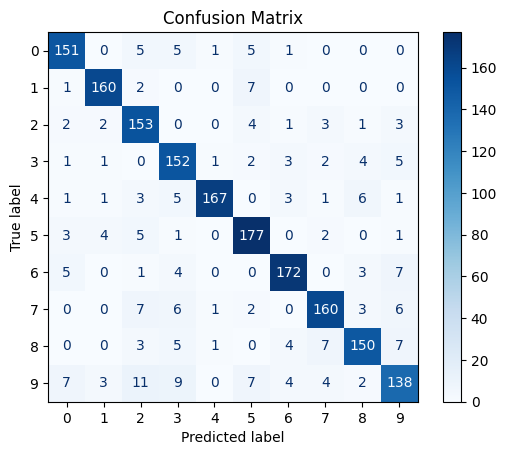

In [77]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# Define RNNClassifier class
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNNClassifier, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        out, _ = self.rnn(x)
        if len(out.shape) == 2:
            out = out.unsqueeze(0)  # Ensure out has shape (batch_size, sequence_length, hidden_size)
        out = self.fc(out[:, -1, :])  # Use only the last output
        out = self.softmax(out)
        return out

# Load the scaled DataFrame
df_scaled = pd.read_csv('audio_5_features_scaled.csv')

# Convert labels to numerical format if necessary
df_scaled['label'] = df_scaled['label'].astype('category').cat.codes

# Split data into features and labels
X = df_scaled.drop(columns=['label']).values
y = df_scaled['label'].values

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Define dataset
dataset = TensorDataset(X_tensor, y_tensor)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize k-fold cross-validation
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)

# Arrays to store results for each fold
train_accs = []
val_accs = []
best_val_accs = []  # Store best validation accuracy for each fold
classification_reports = []

# Start k-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
    print(f'FOLD {fold+1}')
    print('--------------------------------')
    
    # Subset for training and validation
    train_subset = torch.utils.data.Subset(dataset, train_idx)
    val_subset = torch.utils.data.Subset(dataset, val_idx)
    
    # Define data loaders for training and validation
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
    
    # Initialize model, criterion, and optimizer
    input_size = X.shape[1]
    hidden_size = 128
    num_classes = len(np.unique(y))
    model = RNNClassifier(input_size, hidden_size, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    # Training and evaluation for each fold
    num_epochs = 50
    best_val_acc = 0.0
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs.unsqueeze(1))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation after each epoch
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs.unsqueeze(1))
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
            val_acc = val_correct / val_total
            val_accs.append(val_acc)  # Store validation accuracy for this fold
            
            # Check if validation accuracy is the best so far
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                # Save the model state dict if you want to keep the best model
                # best_model_state_dict = model.state_dict()
        
        # Print progress for each epoch (optional)
        # print(f'Epoch [{epoch+1}/{num_epochs}], Val Acc: {val_acc:.4f}')
    
    # Store best validation accuracy for this fold
    best_val_accs.append(best_val_acc)
    
    # Store training accuracy for this fold (only storing the last epoch's accuracy)
    train_accs.append(val_acc)  # Storing val_acc here, since it's the last one seen
    
    # Calculate and store classification report for this fold
    all_true_labels = []
    all_predictions = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.unsqueeze(1))
            _, predicted = torch.max(outputs, 1)
            all_true_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    report = classification_report(all_true_labels, all_predictions, digits=4)
    classification_reports.append(report)
    
    print(f'Best Validation Accuracy for Fold {fold+1}: {best_val_acc:.4f}')
    print('--------------------------------')

# Create a DataFrame to hold results
fold_indices = np.arange(1, k_folds + 1)
results_df = pd.DataFrame({
    'Fold': fold_indices,
    'Train Accuracy': train_accs,
    'Best Validation Accuracy': best_val_accs,
    'Classification Report': classification_reports
})

# Print the results as a table
print("\nCross-validation Results:")
print(results_df)

# Initialize lists to store best precision, recall, f1-score, and support for each fold
best_precision = []
best_recall = []
best_f1_score = []
best_support = []

# Iterate through classification reports for each fold
for report in classification_reports:
    lines = report.split('\n')
    # Parse lines to get precision, recall, f1-score, and support for each class
    data = []
    for line in lines[2:-5]:  # Skip header and 'accuracy' lines
        row_data = line.split()
        if len(row_data) > 0:
            data.append(row_data)
    
    # Extract precision, recall, f1-score, and support for each class
    precision = []
    recall = []
    f1_score = []
    support = []
    for row in data:
        precision.append(float(row[1]))
        recall.append(float(row[2]))
        f1_score.append(float(row[3]))
        support.append(int(row[4]))
    
    # Find the best precision, recall, f1-score, and support for this fold
    best_precision.append(max(precision))
    best_recall.append(max(recall))
    best_f1_score.append(max(f1_score))
    best_support.append(max(support))

# Create DataFrame to hold best precision, recall, f1-score, and support for each fold
best_metrics_df = pd.DataFrame({
    'Fold': fold_indices,
    'Best Precision': best_precision,
    'Best Recall': best_recall,
    'Best F1-Score': best_f1_score,
    'Best Support': best_support
})

# Print the results as a table
print("\nBest Metrics for Each Fold:")
print(best_metrics_df)

# Calculate average accuracies
avg_train_acc = np.mean(train_accs)
avg_best_val_acc = np.mean(best_val_accs)
print(f"\nAverage Train Accuracy: {avg_train_acc:.4f}")
print(f"Average Best Validation Accuracy: {avg_best_val_acc:.4f}")

# Create confusion matrix
cm = confusion_matrix(all_true_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [1]:
import torch
import pickle
import librosa
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load scaler
with open('scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

# Function to extract features from an audio file
def extract_features(file_path, offset):
    try:
        y, sr = librosa.load(file_path, sr=None, offset=offset, duration=5.0)  # Load audio with offset
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

    features = {}

    features['length'] = len(y) / sr
    features['chroma_stft_mean'] = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))
    features['chroma_stft_var'] = np.var(librosa.feature.chroma_stft(y=y, sr=sr))
    features['rms_mean'] = np.mean(librosa.feature.rms(y=y))
    features['rms_var'] = np.var(librosa.feature.rms(y=y))
    features['spectral_centroid_mean'] = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    features['spectral_centroid_var'] = np.var(librosa.feature.spectral_centroid(y=y, sr=sr))
    features['spectral_bandwidth_mean'] = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    features['spectral_bandwidth_var'] = np.var(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    features['rolloff_mean'] = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    features['rolloff_var'] = np.var(librosa.feature.spectral_rolloff(y=y, sr=sr))
    features['zero_crossing_rate_mean'] = np.mean(librosa.feature.zero_crossing_rate(y))
    features['zero_crossing_rate_var'] = np.var(librosa.feature.zero_crossing_rate(y))
    features['harmony_mean'] = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr))
    features['harmony_var'] = np.var(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr))
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    features['perceptr_mean'] = np.mean(mfccs)
    features['perceptr_var'] = np.var(mfccs)
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    tempo = librosa.feature.rhythm.tempo(onset_envelope=onset_env, sr=sr)[0]
    features['tempo'] = tempo

    for i in range(1, 21):
        features[f'mfcc{i}_mean'] = np.mean(mfccs[i-1])
        features[f'mfcc{i}_var'] = np.var(mfccs[i-1])

    return features

# Path to the new audio file
new_audio_file_path = 'C:/Users/gus ryan/iDev/music-classification-models/testing/saturn.mp3'

# Extract features from the new audio file
features = extract_features(new_audio_file_path, 10)

# Prepare features for scaling
features_for_scaling = {k: v for k, v in features.items() if k != 'filename'}  # Exclude 'filename'

# Normalize features
features_arr = np.array([list(features_for_scaling.values())])
features_scaled = scaler.transform(features_arr)

# Handle feature names for scaler if necessary (based on warning)
try:
    features_scaled = scaler.transform(features_arr)
except ValueError as ve:
    print(f"Error in feature scaling: {ve}")

features_tensor = torch.tensor(features_scaled, dtype=torch.float32)

# Example path to the trained model
best_model_path = "C:/Users/gus ryan/iDev/music-classification-models/the_best_model.pkl"

# Load the trained model
with open(best_model_path, 'rb') as file:
    try:
        model = pickle.load(file)
    except AttributeError as ae:
        print(f"AttributeError in loading model: {ae}")

# Move tensor to CUDA if available
if torch.cuda.is_available():
    features_tensor = features_tensor.to('cuda')
    model = model.to('cuda')

# Set model to evaluation mode
model.eval()

# Make prediction
with torch.no_grad():
    outputs = model(features_tensor.unsqueeze(1))  # Add sequence length dimension if needed
    _, predicted = torch.max(outputs, 1)

# Mapping antara label numerik dan nama genre
genre_mapping = {
    0: 'Blues',
    1: 'Classical',
    2: 'Country',
    3: 'Disco',
    4: 'Hiphop',
    5: 'Jazz',
    6: 'Metal',
    7: 'Pop',
    8: 'Reggae',
    9: 'Rock'
}

# Get the predicted label
predicted_label = predicted.item()

# Convert numeric value to genre name using mapping
predicted_genre = genre_mapping[predicted_label]

print(f'Predicted Genre: {predicted_genre}')


AttributeError: No librosa.feature attribute rhythm